# [1] Load Data

In [196]:
import pandas as pd
import numpy as np

In [197]:
# read the data in pandas dataframe
data = pd.read_csv('./dataset/train.csv')

In [198]:
"""Lets have a glimpse of the raw data.
chick dataset/data_description.txt to full feature description 
we have 81 column : 
    79 column is a feature
    1 column Id for each sample 
    1 column for the target feature : SalePrice
"""
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [199]:
"""Get shape of the dataset.
[initial shape] [We have 1460 sample, 81 feature.]
"""
data.shape

(1460, 81)

# [2] Preprocessing

## [2][1] Cleaning Data

In [200]:
"""Funtion to extract the features type from 
the dataset in pandas dataframe.

:param df: dataset represented as dataframe. 

Return:
[features] : [feature type dataframe]
"""
def get_feature_types_stats(df):
    features = df.dtypes.rename('feature_type').reset_index().rename(columns={'index':'feature'})
    return features

In [201]:
"""Funtion to get missing data statistics
as pandas dataframe. count and percentage missing data for each feature,
in addition, type of each feature containing missing data.

:function get_feature_types_stats(df): function required to extract feature type.

Return:
[missing_stats] : [statistics of features contaning missing data as dataframe]
"""
def get_feature_stats(df):
    missing_stats = df.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'feature'})
    missing_stats['missing_percentage'] = missing_stats['missing_count']/df.shape[0]
    
    feature_types_df = get_feature_types_stats(df)
    
    missing_stats = missing_stats.merge(feature_types_df,
                         left_on='feature',
                         right_on='feature',
                         how='left')
    return missing_stats

In [202]:
# generate feature statistics 
missing_stats = get_feature_stats(data)

# sorting by missing percentage in ascending way
missing_stats.sort_values('missing_percentage')

,feature,missing_count,missing_percentage,feature_type
0,Id,0,0.000000,int64
38,TotalBsmtSF,0,0.000000,int64
39,Heating,0,0.000000,object
79,SaleCondition,0,0.000000,object
41,CentralAir,0,0.000000,object
...,...,...,...,...
57,FireplaceQu,690,0.472603,object
73,Fence,1179,0.807534,object
6,Alley,1369,0.937671,object
74,MiscFeature,1406,0.963014,object


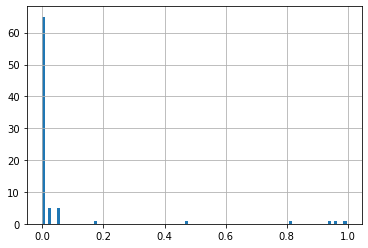

In [203]:
"""Show statistics as histogram.
[x-axis]:[missing_percentage]
[y-axis]:[feature count for each missing_percentage]
"""
missing_stats['missing_percentage'].hist(bins=100)

In [204]:
# I will decide to delete all features with more than 10% 
features_to_delete = missing_stats[missing_stats['missing_percentage'] > 0.1]['feature'].values
features_to_delete

array(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'], dtype=object)

In [205]:
# delete the feature which have missing_percentage more than 10%
data.drop(columns=features_to_delete, inplace=True)

In [206]:
""" Get shape of the dataset after cleaning features
[output] [We have 1460 sample, 75 feature.]
"""
data.shape

(1460, 75)

In [207]:
"""Re compute and skip features with no missing.
[output] [13 feature need to clean their samples.]
"""
missing_stats = get_feature_stats(data)
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type
23,MasVnrType,8,0.005479,object
24,MasVnrArea,8,0.005479,float64
28,BsmtQual,37,0.025342,object
29,BsmtCond,37,0.025342,object
30,BsmtExposure,38,0.026027,object
31,BsmtFinType1,37,0.025342,object
33,BsmtFinType2,38,0.026027,object
40,Electrical,1,0.000685,object
55,GarageType,81,0.055479,object
56,GarageYrBlt,81,0.055479,float64


In [208]:
"""Fill the missing values
[object data type feature] : [Fill with mostly used value]
[float data type feature] : [Fill with mean value]
""" 
for column in missing_stats['feature'] :
    if np.dtype(data[column]) == 'object' :
        mostly_used = data[column].value_counts().reset_index()['index'][0]
        data[column].fillna(mostly_used, inplace=True)
    if  np.dtype(data[column]) == 'float64':
        data[column].fillna(data[column].mean(), inplace=True)

In [209]:
"""Re compute and skip features with no missing.
[output] [No feature need to clean their samples.]
"""
missing_stats = get_feature_stats(data)
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type


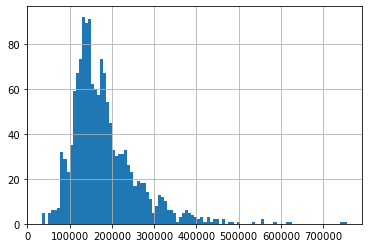

In [210]:
""" Display target variable as histogram to 
view skwed and outlier if any.

[x-axis]:[sale price feature]
[y-axis]:[frequency of each sale price value]
"""
data['SalePrice'].hist(bins=100)

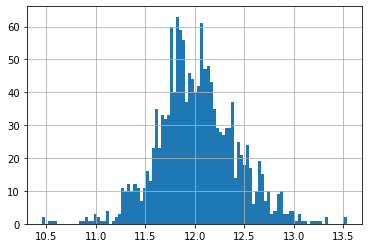

In [211]:
""" Display target variable as histogram to 
view skwed if I apply the Log transformation.

[x-axis]:[sale price feature]
[y-axis]:[frequency of each sale price value]
"""
df_log = np.log(data['SalePrice'])
df_log.hist(bins=100)

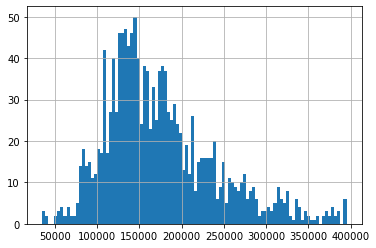

In [212]:
""" Display target variable as histogram to 
view skwed if I remove the outlier.

[x-axis]:[sale price feature]
[y-axis]:[frequency of each sale price value]
"""
data_re = data[data['SalePrice'] < 400000]['SalePrice']
data_re.hist(bins=100)

In [213]:
# I decided not to delete the outlier and go to the Data Tranformation section directly.

# [2][2] Data Tranformatin

### [2][2][1] Working with Numeric Features

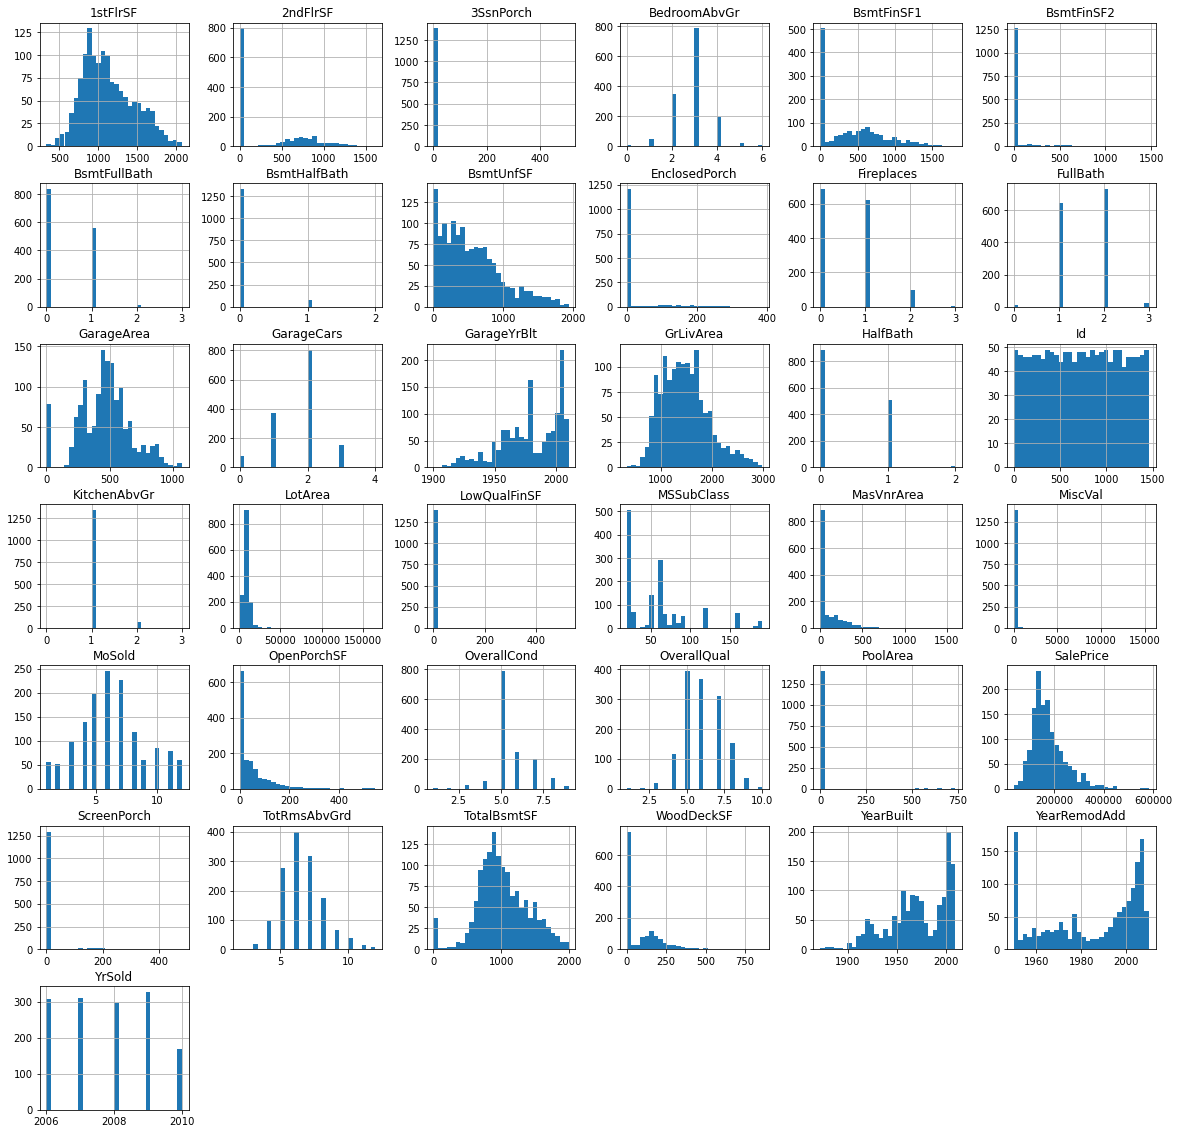

In [237]:
"""Extract the numaric data whether it's
kind of int or float data type.
[output]:[there is 37 features of numaric data type.]
"""
number_features = data.select_dtypes(include=[np.number])
number_features.hist(bins=30, figsize=(20,20))
plt.show()

In [238]:
numeric_features=['1stFlrSF','2ndFlrSF','BsmtFinSF1',
                   'BsmtUnfSF','GarageArea','GarageYrBlt',
                   'GrLivArea', 'LotArea',
                   'MasVnrArea','MoSold','OpenPorchSF',
                   'SalePrice','TotRmsAbvGrd','TotalBsmtSF',
                   'YearBuilt','YearRemodAdd']
numeric_features=data[numeric_features]

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

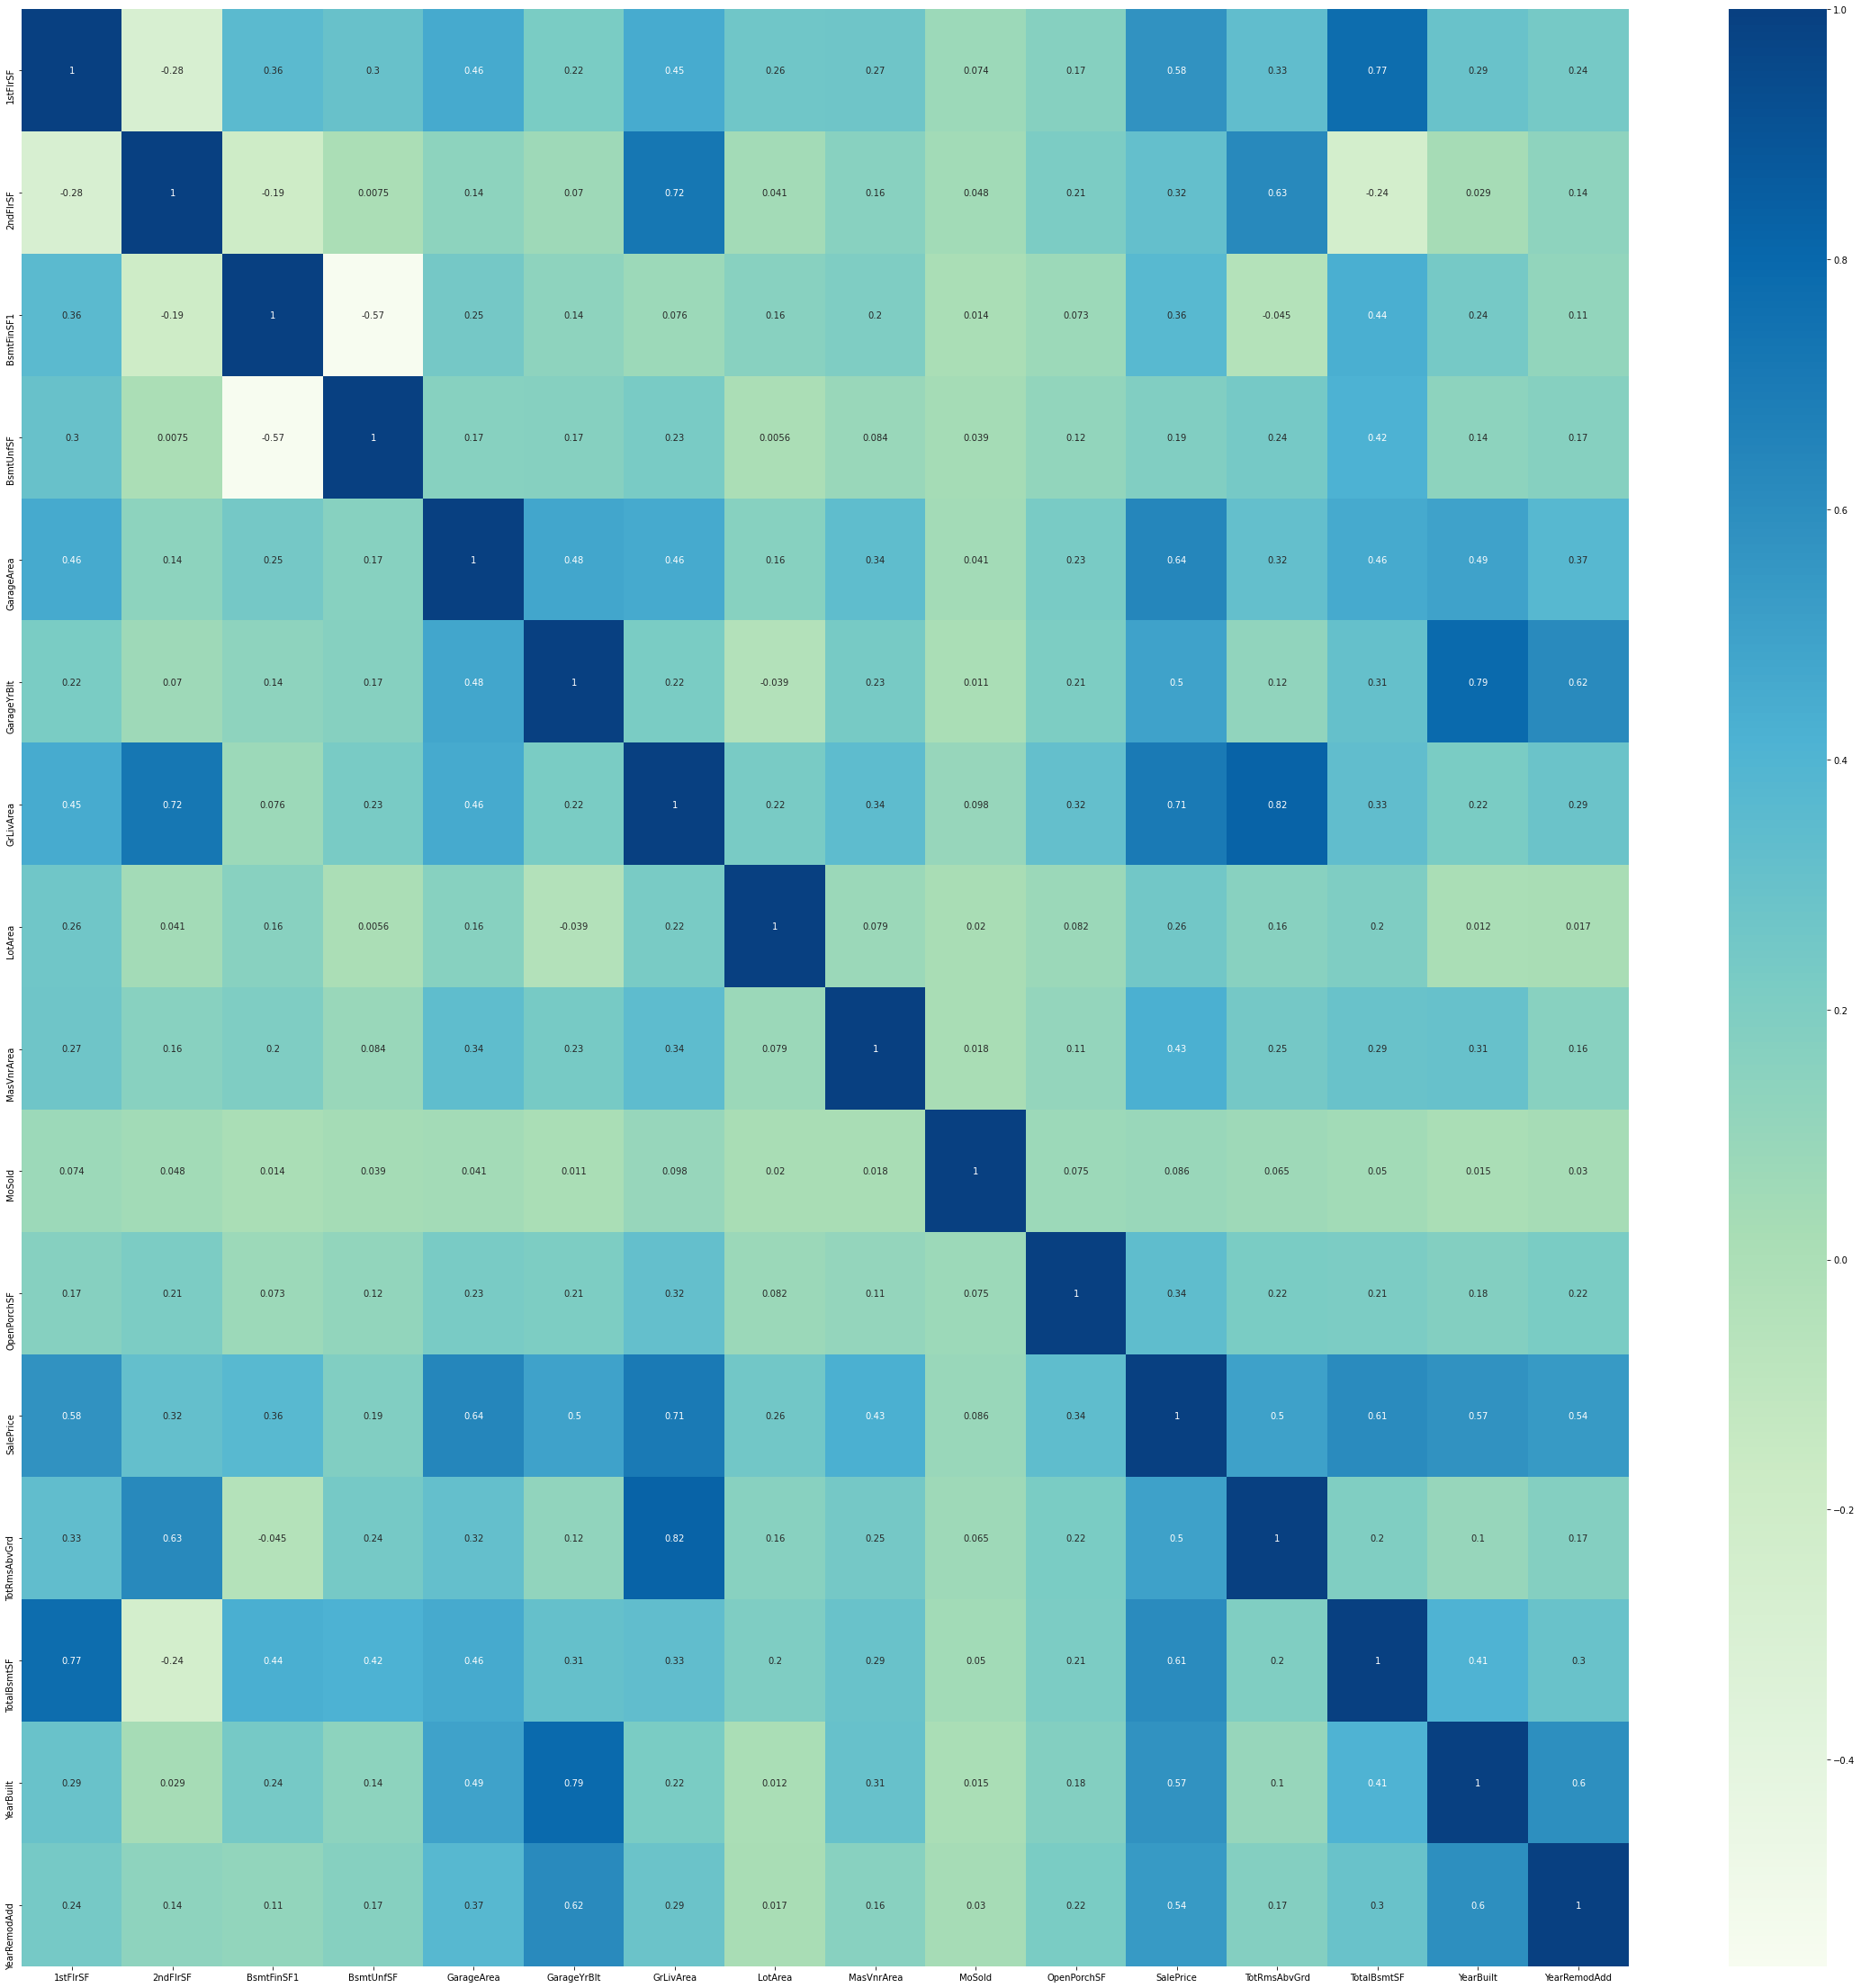

In [240]:
"""Displays the relationship between the columns.
We’ll examine the correlations between the features and the target.
"""
plt.figure(figsize=(40,40))
correlation = numeric_features.corr()
sns.heatmap(correlation, cmap="GnBu", annot = True)

In [241]:
highest_corr = correlation['SalePrice'].sort_values(ascending=False)[:5].reset_index()
highest_corr 

,index,SalePrice
0,SalePrice,1.000000
1,GrLivArea,0.705863
2,GarageArea,0.643895
3,TotalBsmtSF,0.609635
4,1stFlrSF,0.576979


In [242]:
lable=highest_corr['index'].values.tolist()
lable.remove("SalePrice")
lable

['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

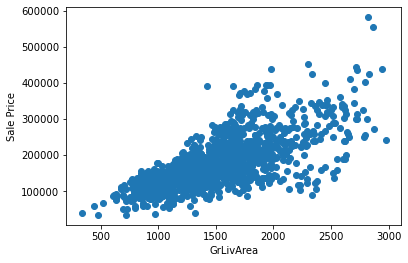

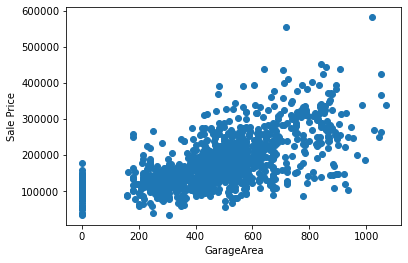

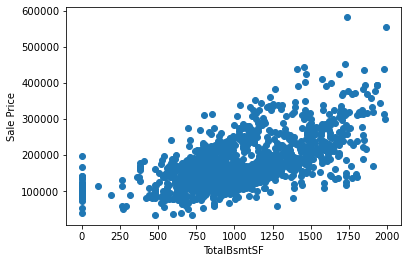

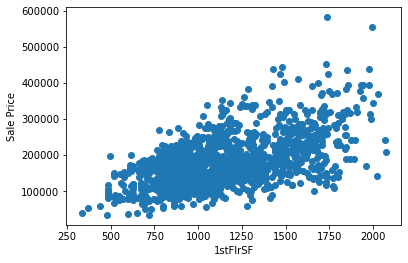

In [243]:
#  Bar plot
for index in lable:
    plt.scatter(x=data[index], y=data['SalePrice'])
    plt.xlabel(index)
    plt.ylabel("Sale Price")
    plt.show()

In [244]:
data = data[data['GrLivArea'] < 3000]
data = data[data['GarageArea'] < 1100]
data = data[data['TotalBsmtSF'] < 2000]
data = data[data['1stFlrSF'] < 2100]

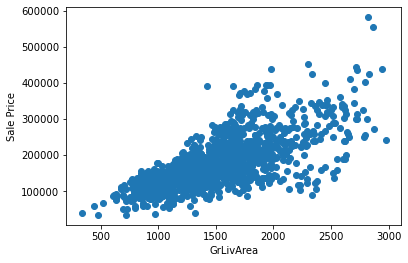

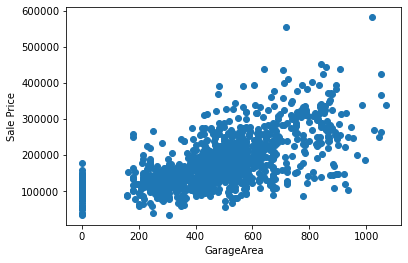

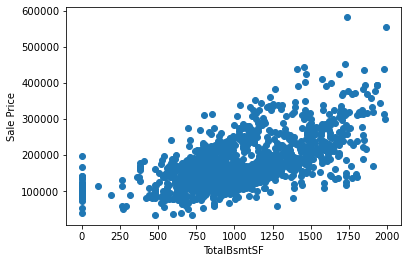

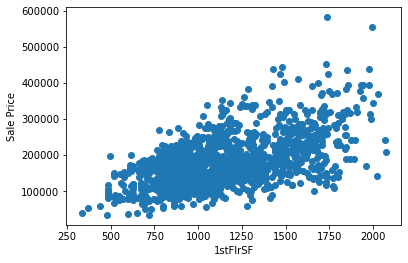

In [245]:
#  Bar plot
for index in lable:
    plt.scatter(x=data[index], y=data['SalePrice'])
    plt.xlabel(index)
    plt.ylabel("Sale Price")
    plt.show()

# [4] Split Data

# [5] Models and Tunning Prameter

# [6] Model Evaluation

# [7] Model Selection

# [8] Pickle

and np.exp() will reverse the transformation.